In [37]:
import pandas as pd
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
#Importing raw data
elecequip = pd.read_csv("elecequip.csv")
#Adding time index
elec_index = pd.date_range(start = '1996-01-01', end = '2012-04-01', freq='M').to_pydatetime()
elecequip.index = elec_index
elecequip

,x
1996-01-31,79.35
1996-02-29,75.78
1996-03-31,86.32
1996-04-30,72.60
1996-05-31,74.86
...,...
2011-11-30,93.37
2011-12-31,98.34
2012-01-31,86.44
2012-02-29,85.04


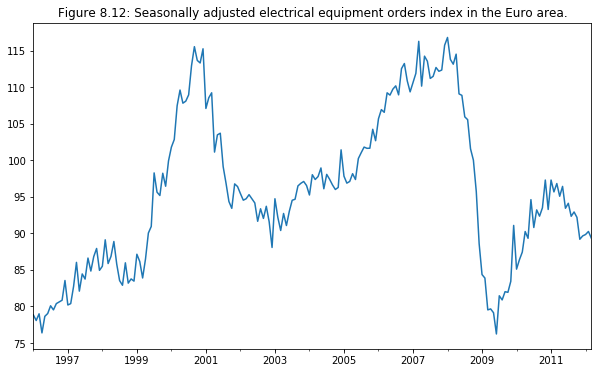

In [3]:
#Seasonal adjustment using STL
from statsmodels.tsa.seasonal import STL
elecequip_stl = STL(elecequip, period=12).fit()
#Subtracting seasonal component
elecequip_adj = pd.DataFrame({'x':elecequip.values[:,0] - elecequip_stl.seasonal.values}, index = elecequip.index)
elecequip_adj.plot.line(title ='Figure 8.12: Seasonally adjusted electrical equipment orders index in the Euro area.', figsize=(10,6), legend=False)


Note that the STL decomposition gives slightly different results than the one inbuilt into R. So the following results will be different as well.

Plotting the first difference

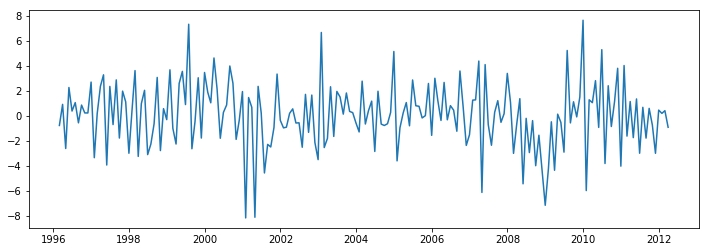

In [4]:
fig, ax = plt.subplots(figsize=(12,4))
eeadj_diff = elecequip_adj.diff()
ax.plot(elecequip_adj.index, elecequip_adj.diff().values)

Plotting the diff with acf and pacf. 
Note that Python does not have an exact analogue as far as I'm aware so the code is quite a bit longer than the one liner in FPP.

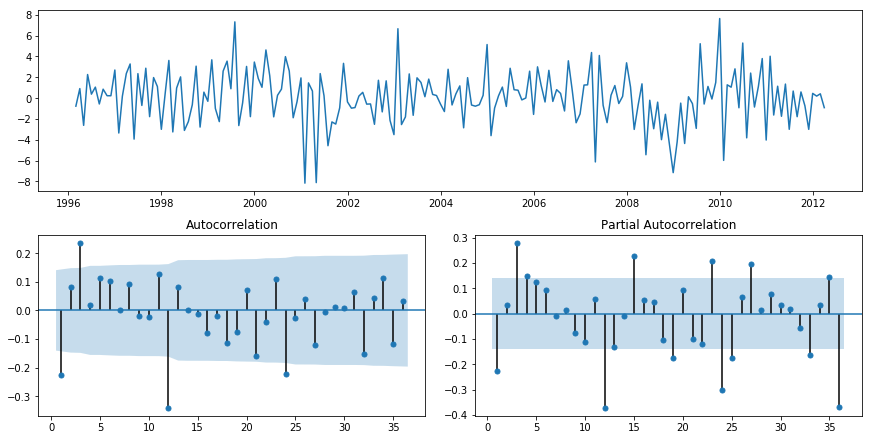

In [5]:
import matplotlib.gridspec as gridspec

fig3 = plt.figure(constrained_layout=True, figsize=(12,6))
gs = fig3.add_gridspec(2, 2)

#Differenced series
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.plot(elecequip_adj.index, eeadj_diff.values)

#Acf
f3_ax2 = fig3.add_subplot(gs[1,0])
acf = statsmodels.graphics.tsaplots.plot_acf(eeadj_diff[1:], ax=f3_ax2, lags=36, zero=False)

#Pacf
f3_ax3 = fig3.add_subplot(gs[1,1])
pacf = statsmodels.graphics.tsaplots.plot_pacf(eeadj_diff[1:], ax=f3_ax3, lags=36, zero=False)

The seasonality doesn't seem to be accounted for, we can still see significant PACF lags at 12, 24 and 36. Perhaps I'm implementing STL wrongly here.

# Fitting an ARIMA model

- Fitting ARIMA(3,1,0) along with variations (4,1,0), (2,1,0) and (3,1,1) 

In [6]:
orders = [(3,1,0), (4,1,0), (2,1,0), (3,1,1)]

for pqd in orders:
    arima_temp = statsmodels.tsa.arima.model.ARIMA(elecequip_adj, dates=elecequip_adj.index, order=pqd, freq='M')
    arima_temp_results = arima_temp.fit()
    print(pqd , 'AIC:', arima_temp_results.aic)

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


(3, 1, 0) AIC: 904.1748030586295
(4, 1, 0) AIC: 902.1467335388884
(2, 1, 0) AIC: 917.343508718647


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


(3, 1, 1) AIC: 899.0877699927275


(3,1,1) has the lowest AIC which is consistent with the results in FPP.

Not sure why I'm getting warnings when I've specified the frequency...

In [11]:
arima_model = statsmodels.tsa.arima.model.ARIMA(elecequip_adj, order=(3,1,1), freq='M')
arima_results = arima_model.fit()
arima_results.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  195
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -444.544
Date:                Tue, 30 Jun 2020   AIC                            899.088
Time:                        15:23:21   BIC                            915.427
Sample:                    01-31-1996   HQIC                           905.704
                         - 03-31-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2602      0.136      1.920      0.055      -0.005       0.526
ar.L2          0.1987      0.095      2.090      0.037       0.012       0.385
ar.L3          0.2639      0.085      3.093      0.002       0.097       0.431
ma.L1         -0.5452      0.145     -3.749      0.000      -0.830      -0.260
sigma2         5.7133      0.544     10.502      0.000       4.647       6.780
===================================================================================
Ljung-Box (Q):                       72.05   Jarque-Bera (JB):                 5.42
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.11   Skew:                             0.10
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Residual Analysis

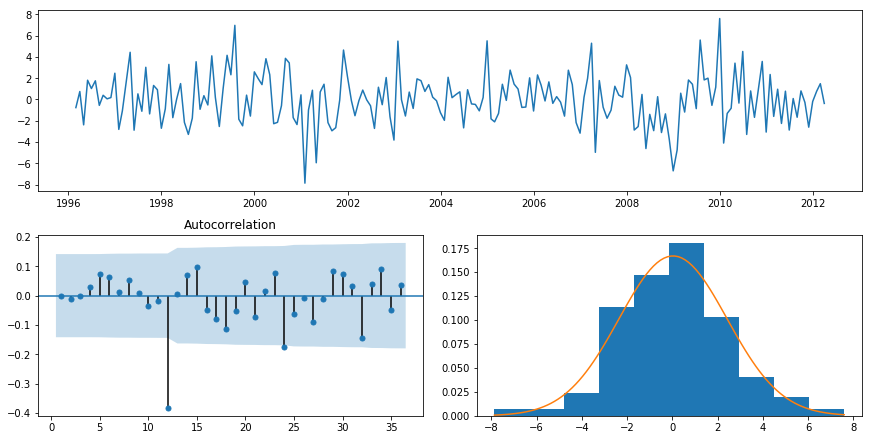

In [77]:
resids = arima_results.resid[1:]
mu, sigma = stats.norm.fit(resids)
lb = min(resids)
ub = max(resids)
domain = np.linspace(lb, ub, 100)
pdf = stats.norm.pdf(domain, loc=mu, scale=sigma)


fig_resids = plt.figure(constrained_layout=True, figsize=(12,6))
gs = fig_resids.add_gridspec(2, 2)

#Differenced series
fig_resids_ax1 = fig_resids.add_subplot(gs[0, :])
fig_resids_ax1.plot(resids.index, resids.values)

#Acf
fig_resids_ax2 = fig_resids.add_subplot(gs[1,0])
acf = statsmodels.graphics.tsaplots.plot_acf(resids[3:], ax=fig_resids_ax2, lags=36, zero=False)

#Histogram
fig_resids_ax3 = fig_resids.add_subplot(gs[1,1])
plt.hist(resids, density=True)
plt.plot(domain, pdf)

##Alternatively if you want to use counts on the histogram. Note that the scaling is arbitrary, you can change it using the number of bins.
#fig_resids_ax3 = fig_resids.add_subplot(gs[1,1])
#plt.hist(resids, 16)
#plt.plot(domain, pdf*len(resids)) 

As mentioned above, there is still very strong seasonality in the residuals. Note that I've elected to use a density/probability in the y-axis for the histogram as the scaling of the pdf to the raw counts is somewhat arbitrary. 

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.plot_predict.html

In [86]:
arima_results.get_forecast(10)